# Word probability and joke length

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# Load direct and inverted indices
import sys
if '..' not in sys.path:
    sys.path.append('..')
from src.utils import LoadIndices, LoadDatasets, TrainTestIdx

# Load datasets
an_jokes, bash_jokes = LoadDatasets()
# Load direct and inverted indices
an_direct, an_inverted, bash_direct, bash_inverted = LoadIndices()

Let's sort jokes according to their length (number of words). Consider cumulative distribution function of word occurences over index in this sorted list. Such functions typically lie between two cases: 
1. probability is proportional to joke length (may be typical for general use words which can be found in any context).
2. probability do not depend on length at all (may be typical for words strongly correlated to some topic)

Figures below shows ideal functions: proportional to length and independant of length.

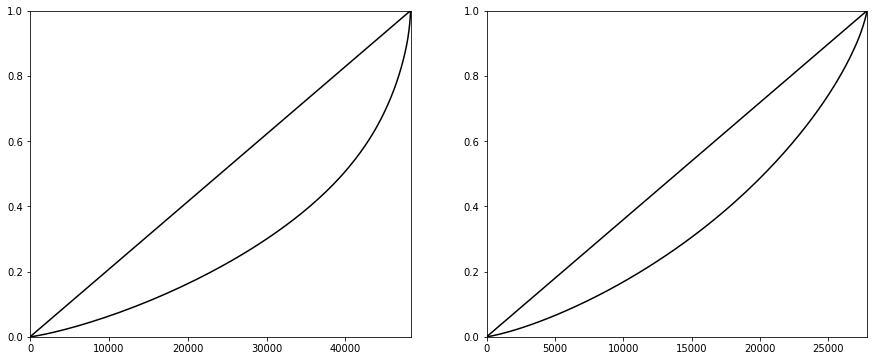

In [28]:
def sort_by_length(direct_index):
    lengths = np.array([sum(d.values()) for d in direct_index])
    idx = np.argsort(lengths)
    return idx, lengths[idx]

def show_ideal_graphs(direct_index):
    num_of_jokes = len(direct_index)
    idx, lengths = sort_by_length(direct_index)
    P = np.zeros(len(lengths) + 1)
    P[1:] = np.cumsum(lengths)
    P = P / P[-1]

    plt.plot(np.arange(num_of_jokes + 1), P, c = 'black')
    plt.plot([0, num_of_jokes], [0, 1], c = 'black')
    plt.xlim(0, num_of_jokes)
    plt.ylim(0, 1)
    
    return idx

plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
an_idx = show_ideal_graphs(an_direct)
plt.subplot(1, 2, 2)
bash_idx = show_ideal_graphs(bash_direct)


In [27]:
an_lengths[:10]

array([ 0,  1, 17, 14, 19, 11, 10, 57, 12, 62], dtype=int64)

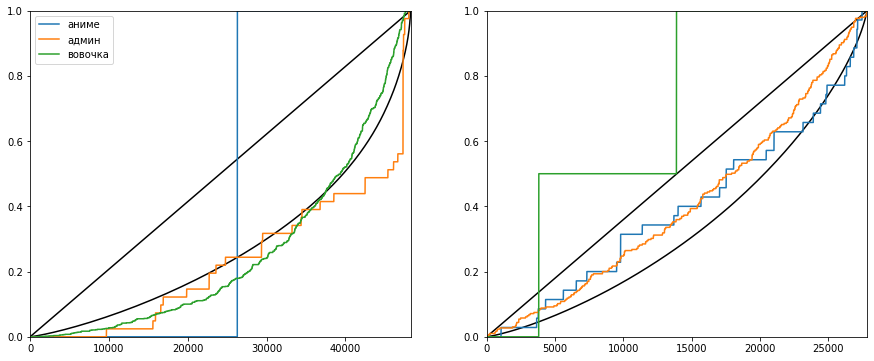

In [61]:
def invert(idx):
    inv_idx = np.zeros(len(idx), dtype = 'int')
    inv_idx[idx] = np.arange(len(idx))
    return inv_idx

def cum_distrib(word, direct_index, inverted_index, inv_idx):
    y = np.zeros(len(direct_index) + 1)
    if word in inverted_index:
        for i in inverted_index[word][0] + inverted_index[word][1]:
            y[inv_idx[i]] = direct_index[i][word]
        y = np.cumsum(y)
        y /= y[-1]
    return y
        
def show_word_distributions(words):
    plt.figure(figsize = (15, 6))
    plt.subplot(1, 2, 1)
    an_idx = show_ideal_graphs(an_direct)
    an_inv_idx = invert(an_idx)
    for word in words: 
        y = cum_distrib(word, an_direct, an_inverted, an_inv_idx)
        plt.plot(range(len(an_direct)+1), y, label = word)
    plt.legend()

    plt.subplot(1, 2, 2)
    bash_idx = show_ideal_graphs(bash_direct)
    bash_inv_idx = invert(bash_idx)
    for word in words: 
        y = cum_distrib(word, bash_direct, bash_inverted, bash_inv_idx)
        plt.plot(range(len(bash_direct)+1), y)
        
    
show_word_distributions(['аниме', 'админ', 'вовочка'])

    
    
    
    
